CAPSTONE Three.

DRAFT

# Hate Speech and Offensive Language detection

## Pre-processing and Training Data Development, Modeling

## Introduction

NLP Model to Predict Hate Speech

Dataset using Twitter data, is was used to research hate-speech detection. The text is classified as: hate-speech, offensive language, and neither. 

- Supervised with NLP - bag of words of models od tf-ids features
- Use Multinomial Naive Bayes algorithm is a probabilistic learning method 
- Random Forest
- Use Bert in multi label Text Classification

### Installation

In [1]:
#import tensorflow as tf

In [2]:
#pip install bert-for-tf2

In [3]:
#pip install pytorch-pretrained-bert

In [4]:
#pip install pytorch-nlp

In [5]:
#pip install -q tensorflow-text

In [6]:
#pip install nltk

## Imports

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from scipy import stats
# random enables us to generate random numbers
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split



In [8]:
from sklearn import tree, metrics
from io import StringIO
from IPython.display import Image  
import pydotplus

from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report


In [9]:

import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
#from bs4 import BeautifulSoup
import unicodedata

from nltk.tokenize import TweetTokenizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natakat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import sys
import torch

from pytorch_pretrained_bert import BertModel
from torch import nn

from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output


##  Load the data

Load the Hate Speach and Offensive language dataset (labeled_data.csv)

In [11]:
hate_speach = pd.read_csv('../data/labeled_data.csv')

In [12]:
hate_speach

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [13]:
hate_speach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [14]:
hate_speach.shape

(24783, 7)

 # 4. Pre-processing and Training Data Development

The text is classified as: hate-speech, offensive language, and neither.
* hate speech it is labelled as 0
* offensive it is labelled as 1
* neither then it is class 2

The dataset has 7 columns. We will drop all the columns that contailn numbers of CF users who judged the tweet and keep only 2 columns: the tweet and class

In [15]:
hs = hate_speach[['class', 'tweet']]
hs

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [16]:
# Grouping data by label
hs.groupby('class').count()

,tweet
class,
0,1430
1,19190
2,4163


In [17]:
 def percentage(part, whole):
  Percentage = round(100 * float(part)/float(whole),2)
  return str(Percentage) + "%"

In [18]:
hate, offensive, neither = np.bincount(hs['class'])
whole = hate + offensive + neither


In [19]:
hate_pr = percentage(hate,whole)
offensive_pr = percentage(offensive,whole)
neither_pr = percentage(neither,whole)

In [20]:
print("Total : " + str(whole))
print()
print("Hate : " + hate_pr + " of total")
print("Offensive : " + offensive_pr + " of total")
print("Neither : " + neither_pr + " of total")

Total : 24783

Hate : 5.77% of total
Offensive : 77.43% of total
Neither : 16.8% of total


This is an unbalanced dataset.

/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


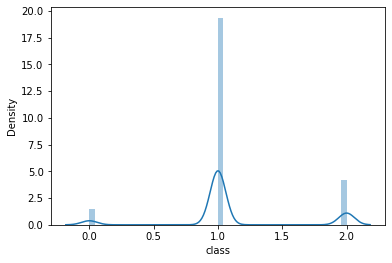

In [21]:
import seaborn as sn
sn.distplot(hs['class'])
plt.show()

### 4.1 Create dummy or indicator features for categorical variables

In [22]:
tweet = hs.drop('class', axis=1)
categories = hs['class']

Although some machine learning algorithms can interpret multi-level categorical variables, many machine learning models cannot handle categorical variables unless they are converted to dummy variables.

In [23]:
cat = pd.get_dummies(categories)

where hate speech it is labelled as 0, offensive it is labelled as 1 
neither then it is class 2

In [24]:
cat.describe()

,0,1,2
count,24783.000000,24783.000000,24783.000000
mean,0.057701,0.774321,0.167978
std,0.233182,0.418037,0.373854
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [25]:
df = pd.concat([hs.drop("class", axis=1), pd.get_dummies(categories)], axis=1)
df

,tweet,0,1,2
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,1
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0,1,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0,1,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0,1,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0,1,0
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,0,1,0
24779,"you've gone and broke the wrong heart baby, an...",0,0,1
24780,young buck wanna eat!!.. dat nigguh like I ain...,0,1,0
24781,youu got wild bitches tellin you lies,0,1,0


In [26]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 


[nltk_data] Downloading package wordnet to /Users/natakat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>@')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


In [28]:
df['cleanTweet']=df['tweet'].map(lambda s:preprocess(s)) 
tweet_tokenizer = TweetTokenizer()
df['tokenized_tweets'] = df['cleanTweet'].apply(tweet_tokenizer.tokenize)
df

,tweet,0,1,2,cleanTweet,tokenized_tweets
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,1,mayasolovely woman complain cleaning house amp...,"[mayasolovely, woman, complain, cleaning, hous..."
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0,1,0,mleew boy dats cold tyga dwn bad cuffin dat ho...,"[mleew, boy, dats, cold, tyga, dwn, bad, cuffi..."
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0,1,0,urkindofbrand dawg sbabylife ever fuck bitch s...,"[urkindofbrand, dawg, sbabylife, ever, fuck, b..."
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0,1,0,c_g_anderson viva_based look like tranny,"[c_g_anderson, viva_based, look, like, tranny]"
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0,1,0,shenikaroberts shit hear might true might fake...,"[shenikaroberts, shit, hear, might, true, migh..."
...,...,...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,0,1,0,muthaf lie lifeasking _pearls corey_emanuel ri...,"[muthaf, lie, lifeasking, _pearls, corey_emanu..."
24779,"you've gone and broke the wrong heart baby, an...",0,0,1,gone broke wrong heart baby drove redneck crazy,"[gone, broke, wrong, heart, baby, drove, redne..."
24780,young buck wanna eat!!.. dat nigguh like I ain...,0,1,0,young buck wanna eat dat nigguh like aint fuck...,"[young, buck, wanna, eat, dat, nigguh, like, a..."
24781,youu got wild bitches tellin you lies,0,1,0,youu got wild bitches tellin lies,"[youu, got, wild, bitches, tellin, lies]"


In [29]:
df = df.drop("tweet", axis=1)
df

,0,1,2,cleanTweet,tokenized_tweets
0,0,0,1,mayasolovely woman complain cleaning house amp...,"[mayasolovely, woman, complain, cleaning, hous..."
1,0,1,0,mleew boy dats cold tyga dwn bad cuffin dat ho...,"[mleew, boy, dats, cold, tyga, dwn, bad, cuffi..."
2,0,1,0,urkindofbrand dawg sbabylife ever fuck bitch s...,"[urkindofbrand, dawg, sbabylife, ever, fuck, b..."
3,0,1,0,c_g_anderson viva_based look like tranny,"[c_g_anderson, viva_based, look, like, tranny]"
4,0,1,0,shenikaroberts shit hear might true might fake...,"[shenikaroberts, shit, hear, might, true, migh..."
...,...,...,...,...,...
24778,0,1,0,muthaf lie lifeasking _pearls corey_emanuel ri...,"[muthaf, lie, lifeasking, _pearls, corey_emanu..."
24779,0,0,1,gone broke wrong heart baby drove redneck crazy,"[gone, broke, wrong, heart, baby, drove, redne..."
24780,0,1,0,young buck wanna eat dat nigguh like aint fuck...,"[young, buck, wanna, eat, dat, nigguh, like, a..."
24781,0,1,0,youu got wild bitches tellin lies,"[youu, got, wild, bitches, tellin, lies]"


In [30]:
df.to_csv('../data/clean_tweets.csv') 

In [31]:
hs['cleanTweet']=hs['tweet'].map(lambda s:preprocess(s)) 


/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
hs.rename(columns={'class' : 'label'}, inplace=True)


/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 4.2. Standardize the magnitude of numeric features

This is not applied in our situation. We don't have numeric features with different magnitude. 

## Word Clouds 

Word Clouds are a popular way of displaying how important words are in a collection of texts. 
The more frequent the word is, the greater space it occupies in the image. 

#### Offensive language

<class 'set'>


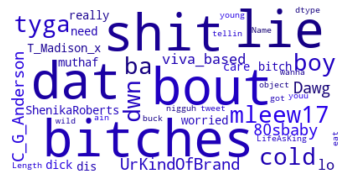

In [33]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 250
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(hs.loc[hs["label"]==1].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

#### Hate language

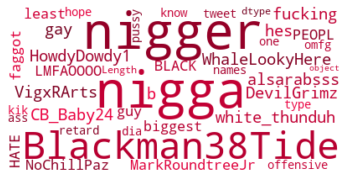

In [34]:
stopwords.add("Name")

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str((hs.loc[hs["label"]==0].tweet)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

## 5 Modeling

### Word embeddings

#### Bag of words and Tf-idf

Use Bag-of-words vectors (build in scikit-learn) to predict the text label(category) based on the tweets wording.

The data set we extracted has categorical features we generated using preprocessing

The BoW method is simple and works well, but it treats all words equally and cannot distinguish very common words or rare words. Tf-idf solves this problem of BoW Vectorization.

Both Vectorization techniques, BoW and tf-idf work well but it fails to suggest a relation between two words. Vectorization using word embedding solves this problem. We will discuss word embedding 

In [35]:
hs

,label,tweet,cleanTweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely woman complain cleaning house amp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,mleew boy dats cold tyga dwn bad cuffin dat ho...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,urkindofbrand dawg sbabylife ever fuck bitch s...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,c_g_anderson viva_based look like tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shenikaroberts shit hear might true might fake...
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf lie lifeasking _pearls corey_emanuel ri...
24779,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


In [36]:
#target
y = hs.label

In [37]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hs["tweet"], y,test_size=0.25, random_state=0)

#### CountVectorizer for text classification

In [38]:
count_vectorizer = CountVectorizer(stop_words="english")

In [39]:
# Transform the training data using only the 'tweet' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

#### TfidfVectorizer for text classification

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)


### Inspecting the vectors

In [41]:
# tfidf_vectorizer the first 10 features
tfidf_vectorizer.get_feature_names()[:10]

/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000',
 '0000000000000',
 '003',
 '007',
 '007beardownjedi',
 '007hertzrumble',
 '007m_h',
 '00_jackie',
 '00am']

In [42]:
# The first 5 vectors of the tfidf training data
tfidf_train.A[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Create the CountVectorizer and TfidfVectorizer dataframes

In [43]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names() )

#### CountVectorizer

In [44]:
count_df.head()

,00,000,0000000000000,003,007,007beardownjedi,007hertzrumble,007m_h,00_jackie,00am,...,zwhite93,zwithr,zwnbhpdz8e,zwttsb9cc1,zxuxfxpzi7,zzachbarness,zzkagxivlu,zzzentropy,zzzquil,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TfidfVectorizer

In [45]:
tfidf_df.head()

,00,000,0000000000000,003,007,007beardownjedi,007hertzrumble,007m_h,00_jackie,00am,...,zwhite93,zwithr,zwnbhpdz8e,zwttsb9cc1,zxuxfxpzi7,zzachbarness,zzkagxivlu,zzzentropy,zzzquil,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate the difference in columns

In [46]:
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

### Check whether the DataFrames are equal

In [47]:
count_df.equals(tfidf_df)

False

In [48]:
hs

,label,tweet,cleanTweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,mayasolovely woman complain cleaning house amp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,mleew boy dats cold tyga dwn bad cuffin dat ho...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,urkindofbrand dawg sbabylife ever fuck bitch s...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,c_g_anderson viva_based look like tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shenikaroberts shit hear might true might fake...
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf lie lifeasking _pearls corey_emanuel ri...
24779,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


## Naive Bayes model

Commonly used when training a new supervised model using text vector data


#### Train and test a Naive Bayes model using the CountVectorizer data.

In [49]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)



#### Calculate the accuracy score

In [50]:
score = metrics.accuracy_score(y_test, pred)
score

0.8624919302775984

#### Calculate the confusion matrix

In [51]:
cm = metrics.confusion_matrix(y_test,pred, labels=[0, 2])
cm

array([[ 14,  28],
       [  3, 593]])

<AxesSubplot:>

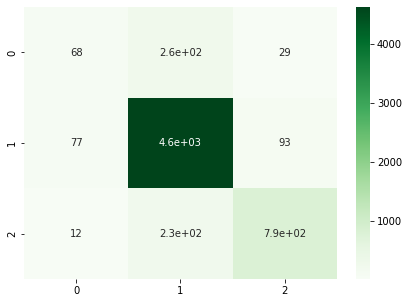

In [66]:
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap ='Greens')

#### Train and test a Naive Bayes model using the TfidfVectorizer

In [52]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)


In [53]:
# Calculate the accuracy score
accuracy = metrics.accuracy_score(y_test, pred)
accuracy

0.7942220787604907

In [54]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 2])
cm

array([[  0,   2],
       [  0, 124]])

<AxesSubplot:>

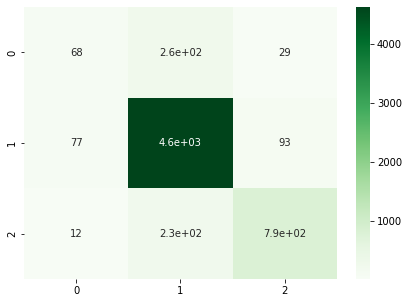

In [65]:
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap ='Greens')

## Classification with Random Forest

The random forest algorithm works by completing the following steps:

    * select random samples from the dataset provided.
    * create a decision tree for each sample selected. Then it will get a prediction result from each decision tree created.
    * voting will then be performed for every predicted result. For a classification problem, it will use mode, and for a regression problem, it will use mean.
    * select the most voted prediction result as the final prediction.

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
X_train, X_test, y_train, y_test = train_test_split(hs["cleanTweet"], y,test_size=0.25, random_state=0)

In [57]:
classifier_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier_rf.fit(count_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [58]:
y_pred_rf = classifier_rf.predict(count_test)
cm = confusion_matrix(y_test, y_pred_rf)
cm

array([[  68,  262,   29],
       [  77, 4630,   93],
       [  12,  233,  792]])

<AxesSubplot:>

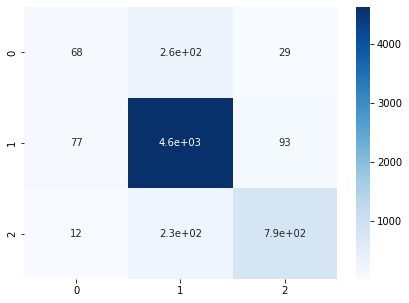

In [64]:
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap ='Blues')

In [59]:
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
accuracy

0.8860555196901226

## Deep neural network for hate speech detection

In [68]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [69]:
df

,0,1,2,cleanTweet,tokenized_tweets
0,0,0,1,mayasolovely woman complain cleaning house amp...,"[mayasolovely, woman, complain, cleaning, hous..."
1,0,1,0,mleew boy dats cold tyga dwn bad cuffin dat ho...,"[mleew, boy, dats, cold, tyga, dwn, bad, cuffi..."
2,0,1,0,urkindofbrand dawg sbabylife ever fuck bitch s...,"[urkindofbrand, dawg, sbabylife, ever, fuck, b..."
3,0,1,0,c_g_anderson viva_based look like tranny,"[c_g_anderson, viva_based, look, like, tranny]"
4,0,1,0,shenikaroberts shit hear might true might fake...,"[shenikaroberts, shit, hear, might, true, migh..."
...,...,...,...,...,...
24778,0,1,0,muthaf lie lifeasking _pearls corey_emanuel ri...,"[muthaf, lie, lifeasking, _pearls, corey_emanu..."
24779,0,0,1,gone broke wrong heart baby drove redneck crazy,"[gone, broke, wrong, heart, baby, drove, redne..."
24780,0,1,0,young buck wanna eat dat nigguh like aint fuck...,"[young, buck, wanna, eat, dat, nigguh, like, a..."
24781,0,1,0,youu got wild bitches tellin lies,"[youu, got, wild, bitches, tellin, lies]"


### Glove Word Embeddings with Keras

Tweets cannot be directly interpreted we need to transform them in a sequence of meaningful integer number in order to be analyzed by NN model

In [71]:
from keras.preprocessing.text import Tokenizer

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:60240)
Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/google/auth/crypt/rsa.py", line 20, in <module>
    from google.auth.crypt import _cryptography_rsa
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/google/auth/crypt/_cryptography_rsa.py", line 22, in <module>
    import cryptography.exceptions
ModuleNotFoundError: No module named 'cryptography'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/sit

ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/eager/context.py)

In [ ]:
nltk.download('reuters')

## Training Models with NLU

In [60]:
import nlu

In [61]:
nlu.load('glove').predict('He was suprised by the diversity of NLU')

Ivy Default Cache set to: /Users/natakat/.ivy2/cache
The jars for the packages stored in: /Users/natakat/.ivy2/jars
:: loading settings :: url = jar:file:/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8e7ad094-dae5-4123-90fb-2c9ad3a125ee;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.2.3 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found co

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
Download done! Loading the resource.
[ / ]

[ — ]

[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[ | ]sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
Download done! Loading the resource.


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/py4j/java_gateway.py", line 1212, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


#
# A fatal error has been detected by the Java Runtime Environment:
#
#  SIGILL (0x4) at pc=0x000000014fef1c15, pid=46849, tid=0x0000000000009237
#
# JRE version: Java(TM) SE Runtime Environment (8.0_311-b11) (build 1.8.0_311-b11)
# Java VM: Java HotSpot(TM) 64-Bit Server VM (25.311-b11 mixed mode bsd-amd64 compressed oops)
# Problematic frame:
# C  [libtensorflow_framework.2.dylib+0x14c15]  tensorflow::monitoring::MetricDef<(tensorflow::monitoring::MetricKind)1, long long, 2>::MetricDef<char [11], char [7]>(absl::lts_2020_02_25::string_view, absl::lts_2020_02_25::string_view, char const (&) [11], char const (&) [7])+0x125
#
# Failed to write core dump. Core dumps have been disabled. To enable core dumping, try "ulimit -c unlimited" before starting Java again
#
# An error report file with more information is saved as:
# /Users/natakat/Springboard/Capstone Three/Notebook/hs_err_pid46849.log
#
# If you would like to submit a bug report, please visit:
#   http://bugreport.java.com/bugrep

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:60240)
Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/__init__.py", line 349, in load
    pipe = PipelineQueryVerifier.check_and_fix_nlu_pipeline(pipe)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/pipe_logic.py", line 477, in check_and_fix_nlu_pipeline
    pipe = PipelineQueryVerifier.satisfy_dependencies(pipe)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/pipe_logic.py", line 345, in satisfy_dependencies
    is_trainable_pipe=is_trainable))
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/component_resolution.py", line 67, in get_default_component_of_type
    if missing_component_type == 'sentence': return Util('deep_sentence_detector', nlu_ref='sentence')
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-pac

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:60240)
Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/__init__.py", line 349, in load
    pipe = PipelineQueryVerifier.check_and_fix_nlu_pipeline(pipe)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/pipe_logic.py", line 477, in check_and_fix_nlu_pipeline
    pipe = PipelineQueryVerifier.satisfy_dependencies(pipe)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/pipe_logic.py", line 345, in satisfy_dependencies
    is_trainable_pipe=is_trainable))
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/component_resolution.py", line 67, in get_default_component_of_type
    if missing_component_type == 'sentence': return Util('deep_sentence_detector', nlu_ref='sentence')
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-pac

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:60240)
Traceback (most recent call last):
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/__init__.py", line 349, in load
    pipe = PipelineQueryVerifier.check_and_fix_nlu_pipeline(pipe)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/pipe_logic.py", line 477, in check_and_fix_nlu_pipeline
    pipe = PipelineQueryVerifier.satisfy_dependencies(pipe)
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/pipe_logic.py", line 345, in satisfy_dependencies
    is_trainable_pipe=is_trainable))
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-packages/nlu/pipe/component_resolution.py", line 67, in get_default_component_of_type
    if missing_component_type == 'sentence': return Util('deep_sentence_detector', nlu_ref='sentence')
  File "/Users/natakat/opt/anaconda3/envs/tf/lib/python3.7/site-pac

Exception: Something went wrong during loading and fitting the pipe. Check the other prints for more information and also verbose mode. Did you use a correct model reference?

In [ ]:
print(classification_report(y_pred_rf, y_test))

In [ ]:
prediction = nlu.load('sentiment').predict(hs,output_level='document')

In [ ]:
prediction.value_counts().plot.bar(title='Count of each  label predicted')